In [1]:
!pip install emoji
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=05cdececee1636fd4ebc1a16f0d437a2c0b8058a2437236b737c9d356fc62f37
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 116.4 MB/s eta 0:00:00


##Getting the necessary imports


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 432x288 with 0 Axes>

##Custom Function to plot the confusion matrix

In [3]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

##Loading the data

In [4]:
test_data = pd.read_csv("https://raw.githubusercontent.com/psvkaushik/Tweet_Sentiment_Classification/main/data/Corona_NLP_test.xls")
train_data = pd.read_csv("https://raw.githubusercontent.com/psvkaushik/Tweet_Sentiment_Classification/main/data/Corona_NLP_train.csv", encoding='latin-1')

In [5]:
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [6]:
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


since the 'TweetAt' is of date format, we'll be changing that column to datetime format.

In [7]:
train_data['TweetAt'] = pd.to_datetime(train_data['TweetAt'])

To reduce redundancy we drop the duplicates, the column 'OriginalTweet' is used as reference.

In [8]:
train_data.drop_duplicates(subset = 'OriginalTweet', inplace = True)

##Exploring the data

In [9]:
count_dict = train_data['TweetAt'].dt.strftime('%m-%d').value_counts()
count_dict = count_dict.sort_index().reset_index(name='counts')
count_dict = pd.DataFrame(count_dict)


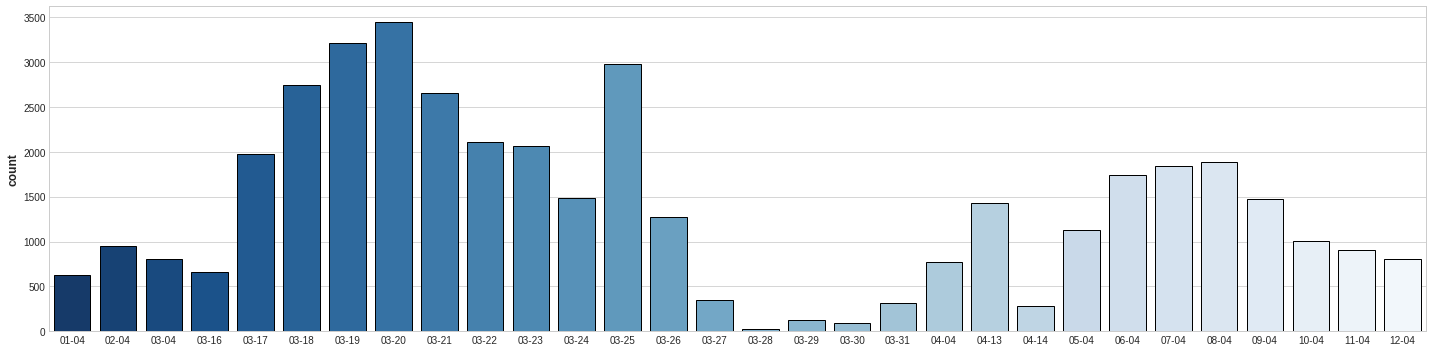

In [10]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=count_dict,edgecolor = 'black',ci=False, palette='Blues_r')

plt.ylabel('count')
plt.xlabel('')
plt.show()

From this we can obsevere that most of the tweets in this data are tweeted during the month of march

### Getting an idea of the nation demographics of the tweets

In [11]:
nation_dict = train_data['Location'].value_counts().loc[lambda x:x>100].reset_index(name='counts')
nation_dict = pd.DataFrame(nation_dict)

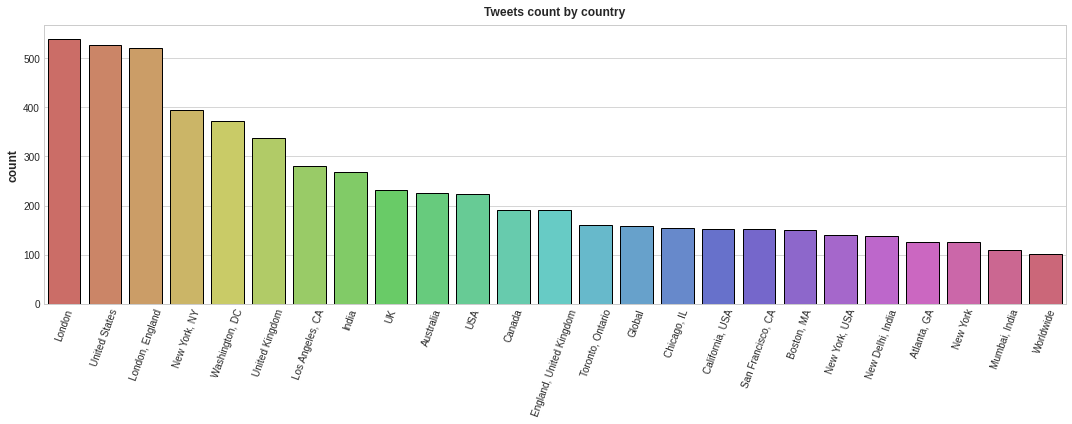

In [12]:
plt.figure(figsize=(15,6))
ax = sns.barplot(x='index', y='counts', data=nation_dict,edgecolor = 'black',ci=False, palette='hls')
plt.title('Tweets count by country')
plt.xticks(rotation=70)
plt.ylabel('count')
plt.xlabel('')
plt.show()

## Cleaning The DATA

 Since tweets contain speacial characters like emojis, hashes, punctuation, etc, we'll filter them before training the models.

 Also since the sentiment is only captured in columns 'OriginalTweet' and 'Sentiment' we will be including only those, where 'OriginalTweet' is our 'X' and 'Sentiment' is our 'Y'/target

In [13]:
df = train_data[['OriginalTweet','Sentiment']]
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [14]:
df_test = test_data[['OriginalTweet', 'Sentiment']]
df_test.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [15]:
#Clean emojis from text
def strip_emoji(text):
    return emoji.replace_emoji(text, replace='') #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [16]:
texts_new = []
for t in df.OriginalTweet:
  texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [17]:
texts_new_test = []
for t in df_test.OriginalTweet:
  texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [18]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

<ipython-input-18-250c9d00a7e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_clean'] = texts_new
<ipython-input-18-250c9d00a7e7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['text_clean'] = texts_new_test


In [19]:
df.head()

,OriginalTweet,Sentiment,text_clean
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and
1,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths to give elder...
3,My food stock is not the only one which is emp...,Positive,my food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready to go at supermarket during the covid...


In [20]:
text_len = []
for text in df['text_clean']:
  text_len.append(len(text.split()))

df['text_len'] = text_len
df.head()

<ipython-input-20-0b93a05b5ed5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = text_len


,OriginalTweet,Sentiment,text_clean,text_len
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and,2
1,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbours family to excha...,38
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths to give elder...,13
3,My food stock is not the only one which is emp...,Positive,my food stock is not the only one which is emp...,41
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready to go at supermarket during the covid...,39


In [21]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

df_test['text_len'] = text_len_test
df_test.head()

<ipython-input-21-b7901a91170c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['text_len'] = text_len_test


,OriginalTweet,Sentiment,text_clean,text_len
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...,21
1,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer at fred mey...,29
2,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...,12
3,#Panic buying hits #NewYork City as anxious sh...,Negative,panic buying hits newyork city as anxious shop...,35
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,toiletpaper dunnypaper coronavirus coronavirus...,25


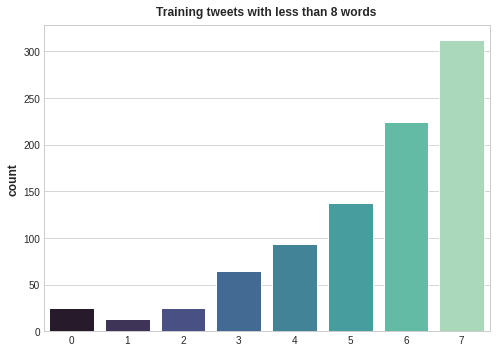

In [22]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<8], palette='mako')
plt.title('Training tweets with less than 8 words')
plt.ylabel('count')
plt.xlabel('')
plt.show()

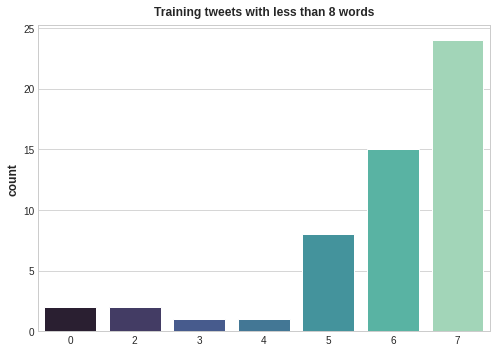

In [23]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<8], palette='mako')
plt.title('Training tweets with less than 8 words')
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [24]:
df = df[df['text_len']>4]
df_test = df_test[df_test['text_len']>4]

In [25]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [26]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")  



INDEX: 1622, TEXT: zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme
INDEX: 13623, TEXT: hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegra s que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarentenanacionalya cuidemosalosquecuidan
INDEX: 16548, TEXT: bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor dn corona tedavisi iin 22 milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta da 35 milyon luk 2 yardm paketi aklanmt viyanadan haberler bu kadar
INDEX: 36953, TEXT: 11 nisan cumartesi itibariyle bbnin tm hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek ve hamidiye su 100 retime geti bb tm stanbulun gda ihtiyacna yetecek kapasitededi

some texts appear to not be in english, let's take a closer look..

In [27]:
df['token_lens'] = token_lens
df = df.sort_values(by = 'token_lens', ascending=False)

Let's remove the tweets which are not in english to avoid confusion for the model.

In [28]:
df = df.iloc[14:]
df.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
8730,?Bitte anschauen! (1/2)\r\r\n\r\r\nEmotionaler...,Negative,bitte anschauen 12 emotionaler aufruf von geha...,36,77
14582,hiked prices in the face of the Covid-19 crise...,Negative,hiked prices in the face of the covid19 crises...,47,77
36305,Sterile disposable anti bacterial wet wipes an...,Negative,sterile disposable anti bacterial wet wipes an...,31,76
36306,For sell Sterile disposable anti bacterial wet...,Negative,for sell sterile disposable anti bacterial wet...,32,75
9238,Hi @Zomato I felt hungry loggd in ur app tryd ...,Extremely Positive,hi i felt hungry loggd in ur app tryd to add 4...,55,75


Just shuffle the text and reset the index.

In [29]:
df = df.sample(frac=1).reset_index(drop=True)

###Cleaning the test dataset in a similar way

In [30]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))


In [31]:
df_test['token_lens'] = token_lens_test

In [32]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(30) 

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl my...,38,96
2383,Ahora seguid llorando por el papel higiénico (...,Negative,ahora seguid llorando por el papel higinico qu...,44,94
345,Informoval jsem zástupce vech obchodních ?et?...,Neutral,informoval jsem zstupce vech obchodnch etzc o ...,31,86
1485,DTF-Dont Touch Face\r\r\nDWBH-Do Wash Both Ha...,Extremely Negative,dtfdont touch face dwbhdo wash both hands gtfo...,42,77
1209,Im in the DC/Maryland/Virginia (DMV) area &am...,Positive,im in the dcmarylandvirginia dmv area amphave ...,45,74
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,43,70
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,stop frenzybuying you dont need most of what y...,38,70


In [33]:
df_test = df_test.iloc[5:]
df_test.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,43,70
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,stop frenzybuying you dont need most of what y...,38,70


In [34]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

##Analysing the target column or the 'Sentiment' column.

In [35]:
df['Sentiment'].value_counts()

Positive              11379
Negative               9889
Neutral                7560
Extremely Positive     6618
Extremely Negative     5475
Name: Sentiment, dtype: int64

Let's merge the positive and extrmely positive into one class, and similarly the negative ones.

In [36]:
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [37]:
df['Sentiment'].value_counts()

2    17997
0    15364
1     7560
Name: Sentiment, dtype: int64

We observe that the classes are imbalanced so we need to balance them to avoid bias.

### OverSampling, UnderSampling

In [38]:
from imblearn.under_sampling import RandomUnderSampler

In [39]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [40]:
ros = RandomUnderSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_us = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [41]:
train_os['Sentiment'].value_counts()

2    17997
1    17997
0    17997
Name: Sentiment, dtype: int64

In [42]:
train_us['Sentiment'].value_counts()

0    7560
1    7560
2    7560
Name: Sentiment, dtype: int64

## Final Data used for Training and Testing

In [43]:
X_os = train_os['text_clean'].values
y_os =  train_os['Sentiment'].values

X_us = train_us['text_clean'].values
y_us =  train_us['Sentiment'].values


In [44]:
X_train_os, X_valid_os, y_train_os, y_valid_os = train_test_split(X_os, y_os, test_size=0.1, stratify=y_os, random_state=seed)
X_train_us, X_valid_us, y_train_us, y_valid_us = train_test_split(X_us, y_us, test_size=0.1, stratify=y_us, random_state=seed)

In [45]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

One-hot encoding will be used for training, but a copy of the original data is stored to use later

In [46]:
y_train_os_le = y_train_os.copy()
y_valid_os_le = y_valid_os.copy()

y_train_us_le = y_train_us.copy()
y_valid_us_le = y_valid_us.copy()

y_test_le = y_test.copy()

In [47]:
ohe = preprocessing.OneHotEncoder()
y_train_os = ohe.fit_transform(np.array(y_train_os).reshape(-1, 1)).toarray()
y_valid_os = ohe.fit_transform(np.array(y_valid_os).reshape(-1, 1)).toarray()

y_train_us = ohe.fit_transform(np.array(y_train_us).reshape(-1, 1)).toarray()
y_valid_us = ohe.fit_transform(np.array(y_valid_us).reshape(-1, 1)).toarray()


y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

## Perfroming Sentiment Analysis Using Different Models

### Using Naive Bayes




Tokenizing the tweets

In [48]:
clf_os = CountVectorizer()
clf_us = CountVectorizer()
X_train_cv_os =  clf_os.fit_transform(X_train_os)
X_train_cv_us =  clf_us.fit_transform(X_train_us)
X_test_cv_os = clf_os.transform(X_test)
X_test_cv_us = clf_us.transform(X_test)

Making the predictions

In [49]:
tf_transformer_os = TfidfTransformer(use_idf=True).fit(X_train_cv_os)
X_train_tf_os = tf_transformer_os.transform(X_train_cv_os)
X_test_tf_os = tf_transformer_os.transform(X_test_cv_os)

nb_clf = MultinomialNB()

nb_clf.fit(X_train_tf_os, y_train_os_le)

nb_pred = nb_clf.predict(X_test_tf_os)

print('\tClassification Report for Naive Bayes on OverSampled data:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes on OverSampled data:

               precision    recall  f1-score   support

    Negative       0.70      0.78      0.74      1629
     Neutral       0.59      0.44      0.50       614
    Positive       0.73      0.72      0.72      1544

    accuracy                           0.70      3787
   macro avg       0.67      0.65      0.66      3787
weighted avg       0.69      0.70      0.69      3787



In [50]:
tf_transformer_us = TfidfTransformer(use_idf=True).fit(X_train_cv_us)
X_train_tf_us = tf_transformer_us.transform(X_train_cv_us)
X_test_tf_us = tf_transformer_us.transform(X_test_cv_us)

nb_clf = MultinomialNB()

nb_clf.fit(X_train_tf_us, y_train_us_le)

nb_pred = nb_clf.predict(X_test_tf_us)

print('\tClassification Report for Naive Bayes on UnderSampled data:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes on UnderSampled data:

               precision    recall  f1-score   support

    Negative       0.71      0.76      0.73      1629
     Neutral       0.60      0.45      0.52       614
    Positive       0.72      0.73      0.73      1544

    accuracy                           0.70      3787
   macro avg       0.67      0.65      0.66      3787
weighted avg       0.69      0.70      0.69      3787



The performance is almost similar on over and under sampled datasets, and the F1 score is decent as well using Naive bayes

### Using the BERT classifier

In [51]:
MAX_LEN = 128
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [52]:
train_input_ids_os, train_attention_masks_os = tokenize(X_train_os, MAX_LEN)
val_input_ids_os, val_attention_masks_os = tokenize(X_valid_os, MAX_LEN)

train_input_ids_us, train_attention_masks_us = tokenize(X_train_us, MAX_LEN)
val_input_ids_us, val_attention_masks_us = tokenize(X_valid_us, MAX_LEN)


test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [53]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [54]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [ ]:
model_os = create_model(bert_model, MAX_LEN)
model_os.summary()

In [59]:
with tf.device('/gpu:0'):
  history_bert_os = model_os.fit([train_input_ids_os,train_attention_masks_os], y_train_os, validation_data=([val_input_ids_os,val_attention_masks_os], y_valid_os), epochs=4, batch_size=32)

Epoch 1/4
1519/1519 [==============================] - 1250s 810ms/step - loss: 0.5523 - categorical_accuracy: 0.7813 - val_loss: 0.3795 - val_categorical_accuracy: 0.8670
Epoch 2/4
1519/1519 [==============================] - 1234s 812ms/step - loss: 0.2949 - categorical_accuracy: 0.8973 - val_loss: 0.2742 - val_categorical_accuracy: 0.9069
Epoch 3/4
1519/1519 [==============================] - 1235s 813ms/step - loss: 0.1993 - categorical_accuracy: 0.9299 - val_loss: 0.2481 - val_categorical_accuracy: 0.9143
Epoch 4/4
1519/1519 [==============================] - 1234s 812ms/step - loss: 0.1361 - categorical_accuracy: 0.9548 - val_loss: 0.2528 - val_categorical_accuracy: 0.9193


In [63]:
result_bert_os = model_os.predict([test_input_ids,test_attention_masks])

119/119 [==============================] - 31s 259ms/step


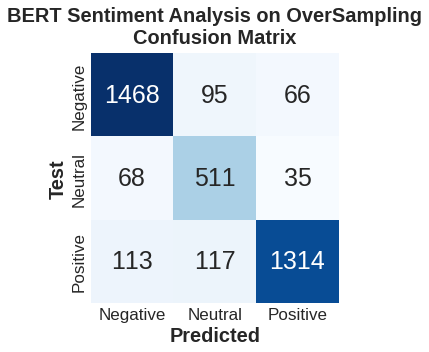

In [64]:
y_pred_bert_os =  np.zeros_like(result_bert_os)
y_pred_bert_os[np.arange(len(y_pred_bert_os)), result_bert_os.argmax(1)] = 1
conf_matrix(y_test.argmax(1), y_pred_bert_os.argmax(1),'BERT Sentiment Analysis on OverSampling\nConfusion Matrix')

In [65]:
print('\tClassification Report for BERT on OverSampling:\n\n',classification_report(y_test,y_pred_bert_os, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT on OverSampling:

               precision    recall  f1-score   support

    Negative       0.89      0.90      0.90      1629
     Neutral       0.71      0.83      0.76       614
    Positive       0.93      0.85      0.89      1544

   micro avg       0.87      0.87      0.87      3787
   macro avg       0.84      0.86      0.85      3787
weighted avg       0.88      0.87      0.87      3787
 samples avg       0.87      0.87      0.87      3787



Using BERT we can see that the performance of our model has improved greatly, as it has F1 score of about 90% for both Negative and Positive cases

In [67]:
tf.keras.models.save_model(model_os,"/content/Model" )